# 05 - Clusterização de Regiões Homogêneas de Precipitação

Este notebook realiza:
1. Cálculo da **climatologia anual** e **climatologia sazonal** (DJF, MAM, JJA, SON) da precipitação.

2. Determinação do **número ótimo de clusters** usando os métodos **Elbow** e **Silhueta**.

3. Aplicação do **Cluster Hierárquico de Ward** para identificar regiões homogêneas.

4. Geração do **mapa final das regiões homogêneas**.

5. Análise das **tendências (MK e Sen’s slope)** por cluster.


## Importações e Configurações

In [83]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import geopandas as gpd
import os
import matplotlib.colors as mcolors
from skimage import measure

## Carregar dados

In [2]:
# Dados originais de precipitação
arquivo_precip = "dataset/netcdf_data/chirps_mensal_1981_2023.nc"
precip = xr.open_dataarray(arquivo_precip)

# Tendências já calculadas (Z e slope) - exemplo para frequência EPI
tendencia_dir = "dataset/netcdf_data/tendencia"
z_freq_epi = xr.open_dataarray(os.path.join(tendencia_dir, "z_freq_epi_anual.nc"))
slope_freq_epi = xr.open_dataarray(os.path.join(tendencia_dir, "slope_freq_epi_anual.nc"))


## Configurando os plots de Precipitação

In [16]:
# Criar colormap customizado: branco em 0, azul escuro no máximo

colors = [(1,1,1), (0.7,0.9,1), (0.2,0.4,0.8)]  # branco -> azul claro -> azul escuro
cmap_custom = mcolors.LinearSegmentedColormap.from_list("white_to_blue", colors)

# Padronizar os plots

def clima_anual(dataarray, titulo, vmin=0, vmax=1500, cmap=cmap_custom):
    plt.figure(figsize=(8,6))
    dataarray.plot(cmap=cmap, vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Precipitação (mm)"})
    plt.title(titulo)
    plt.show()

def plot_season(dataarray, titulo, vmin=0, vmax=450, cmap=cmap_custom):
    plt.figure(figsize=(8,6))
    dataarray.plot(cmap=cmap, vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Precipitação (mm)"})
    plt.title(titulo)
    plt.show()

## Climatologia Anual

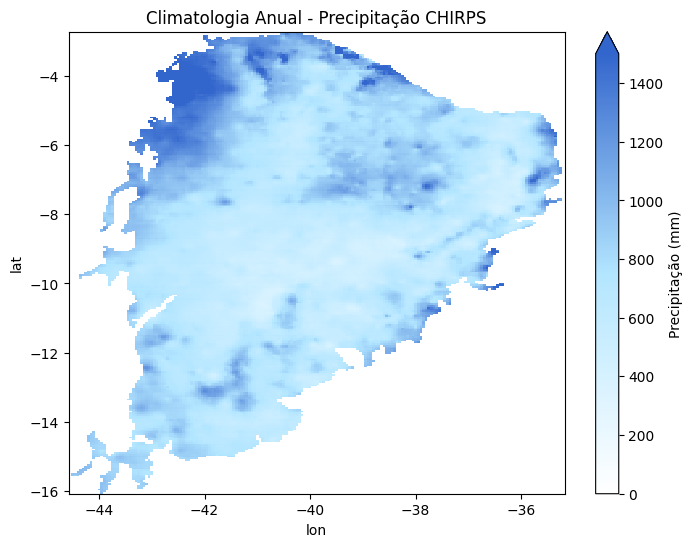

In [15]:
# Média climatológica (1981–2023)
acumulado_anual = precip.groupby("time.year").sum(dim="time")
climatologia_anual = acumulado_anual.mean(dim="year")

clima_anual(climatologia_anual, "Climatologia Anual - Precipitação CHIRPS")


## Climatologia Sazonal

Agrupando os meses em DJF, MAM, JJA, SON

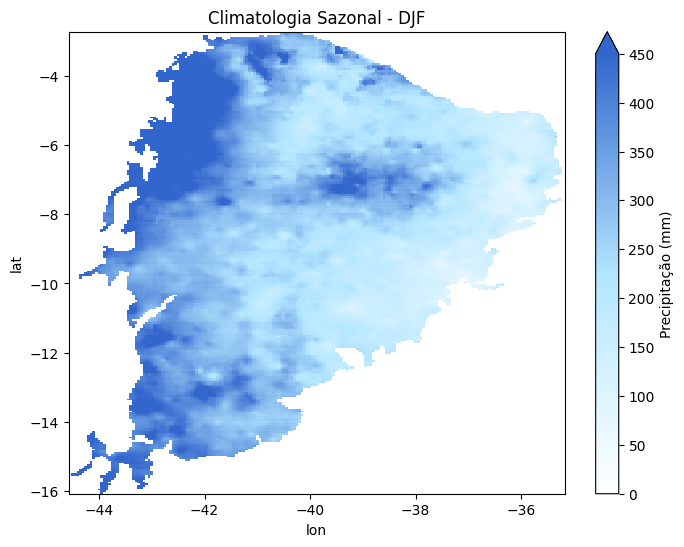

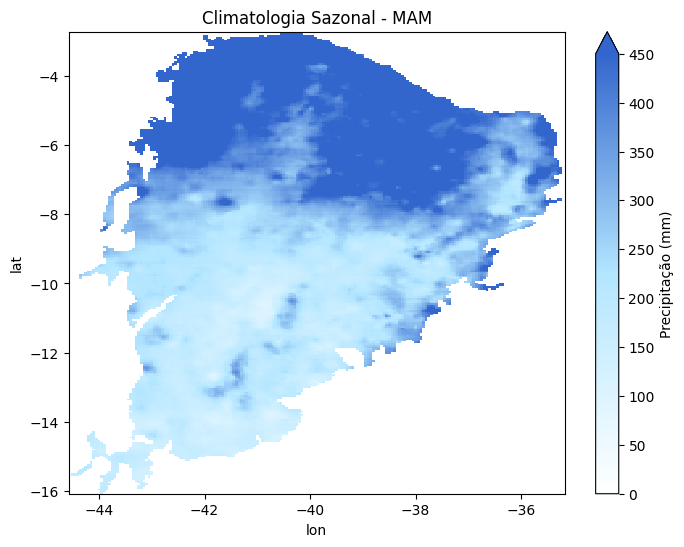

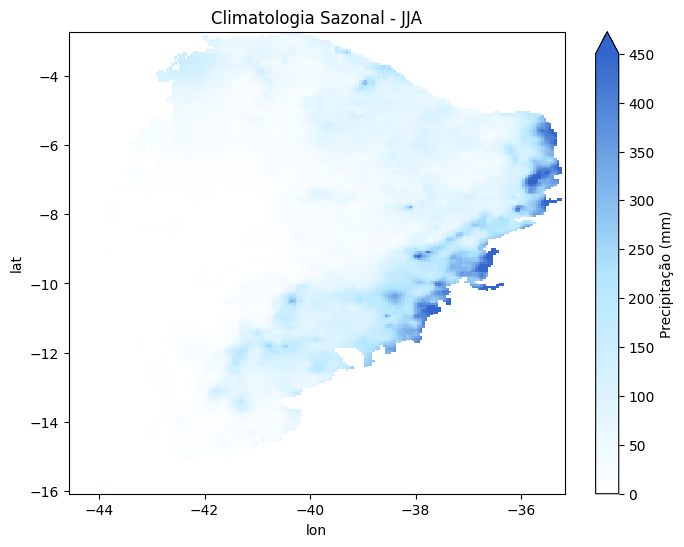

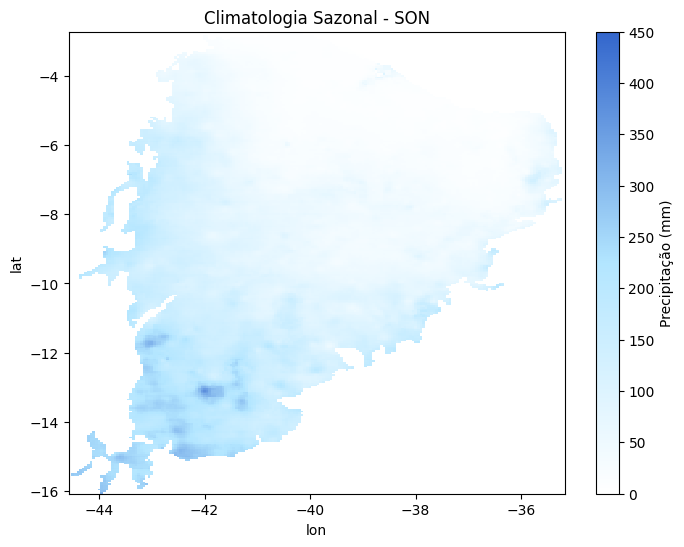

In [22]:
# Definir mapeamento mês → estação
estacoes = {
    12: "DJF", 1: "DJF", 2: "DJF",
    3: "MAM", 4: "MAM", 5: "MAM",
    6: "JJA", 7: "JJA", 8: "JJA",
    9: "SON", 10: "SON", 11: "SON"
}

# Criar chave combinada "ano-estação"
chave_sazonal = [f"{y}-{estacoes[m]}" for y, m in zip(precip["time.year"].values,
                                                      precip["time.month"].values)]
precip.coords["ano_estacao"] = ("time", chave_sazonal)

# Somar meses por chave (ano-estação)
acumulado_sazonal = precip.groupby("ano_estacao").sum(dim="time")

# Extrair estação e ano como novas coords
anos = [int(c.split("-")[0]) for c in acumulado_sazonal.ano_estacao.values]
seasons = [c.split("-")[1] for c in acumulado_sazonal.ano_estacao.values]

acumulado_sazonal = acumulado_sazonal.assign_coords(year=("ano_estacao", anos),
                                                    season=("ano_estacao", seasons))

# Média dos acumulados por estação
climatologia_sazonal = acumulado_sazonal.groupby("season").mean(dim="ano_estacao")

# Plotar climatologia sazonal
for s in ["DJF", "MAM", "JJA", "SON"]:
    plot_season(climatologia_sazonal.sel(season=s), f"Climatologia Sazonal - {s}")

## Clusterização

Variáveis de entrada
* Climatologia anual

* Climatologia sazonal (4 valores)

* Tendência (opcional: slope ou Z de frequência/intensidade EPI)

In [64]:
#mask_valida = (~np.isnan(climatologia_anual.values)) & (climatologia_anual.values > 0)

# Empilhar variáveis em um array 2D (pixels x features)
features = np.stack([
    climatologia_anual.values.flatten(),
    climatologia_sazonal.sel(season="DJF").values.flatten(),
    climatologia_sazonal.sel(season="MAM").values.flatten(),
    climatologia_sazonal.sel(season="JJA").values.flatten(),
    climatologia_sazonal.sel(season="SON").values.flatten(),
    slope_freq_epi.values.flatten()  # exemplo de tendência
], axis=1)

# Remover pixels NaN (mar ou fora do domínio)
mask = (~np.isnan(climatologia_anual.values)) & (climatologia_anual.values > 0)
features_valid = features[mask.flatten()]

# Padronizar
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_valid)


## Determinar número ótimo de clusters


### Método Elbow

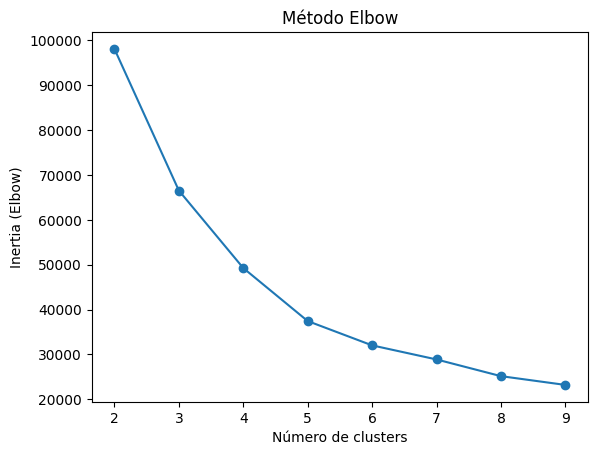

In [70]:
inertias = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(features_scaled)
    inertias.append(km.inertia_)

plt.plot(K, inertias, 'o-')
plt.xlabel("Número de clusters")
plt.ylabel("Inertia (Elbow)")
plt.title("Método Elbow")
plt.show()

### Método Silhueta

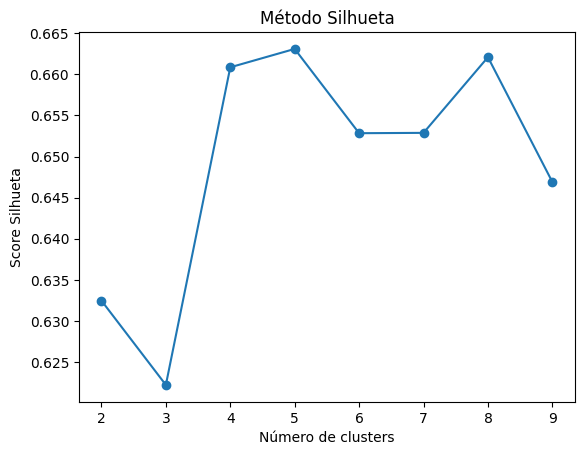

In [26]:
sil_scores = []
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(features_scaled)
    sil = silhouette_score(features_scaled, km.labels_)
    sil_scores.append(sil)

plt.plot(K, sil_scores, 'o-')
plt.xlabel("Número de clusters")
plt.ylabel("Score Silhueta")
plt.title("Método Silhueta")
plt.show()


Com base nos valores dos métodos de estimativa de Clusters, o melhor número de clusters é 5

## Clusterização (Ward)

In [ ]:
# Número de clusters escolhido
n_clusters = 5  # Ajustado conforme decisão baseada nos métodos Elbow/Silhueta
cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels_valid = cluster.fit_predict(features_scaled)

# ========================================================
# 4. Reconstruir mapa de clusters (com fundo NaN)
# ========================================================
labels_map = np.full(mask.shape, np.nan)
labels_map[mask] = labels_valid

# ========================================================
# 5. Renumerar clusters de 0–4 para 1–5
# ========================================================
labels_map = np.where(~np.isnan(labels_map), labels_map + 1, np.nan)


## Cálculo da média anual por cluster

In [71]:
# Extrair valores médios de precipitação por cluster
df_clusters = pd.DataFrame({
    "cluster": labels_map.flatten(),
    "precip": climatologia_anual.values.flatten()
})

# Remover NaN
df_clusters = df_clusters.dropna()

# Calcular média anual por cluster
media_clusters = df_clusters.groupby("cluster")["precip"].mean().round(1)


## Mapa final das regiões homogêneas

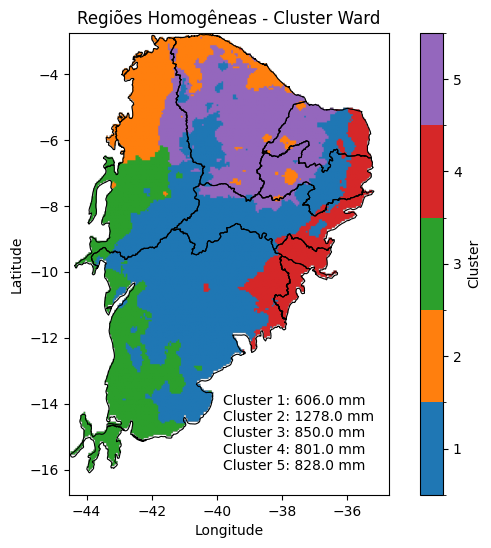

In [80]:
# --- Carregar shapefile ---
shapefile_path = "dataset/shape/caatinga_estados.shp"
gdf_estados = gpd.read_file(shapefile_path)

# Colormap para 5 clusters
cores = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
cmap_categorico = mcolors.ListedColormap(cores[:n_clusters])

bounds = np.arange(0.5, n_clusters + 1.5, 1)  # para clusters 1–5
norm = mcolors.BoundaryNorm(bounds, cmap_categorico.N)

plt.figure(figsize=(8,6))
plt.imshow(labels_map, origin="upper",
           extent=[precip.lon.min(), precip.lon.max(),
                   precip.lat.min(), precip.lat.max()],
           cmap=cmap_categorico, norm=norm)

# Adicionar contorno dos estados (sem preenchimento)
gdf_estados.boundary.plot(ax=plt.gca(), color='black', linewidth=0.8)

cbar = plt.colorbar(ticks=np.arange(1, n_clusters+1))
cbar.set_label("Cluster")

# Adicionar caixa de texto com médias
texto_media = "\n".join([f"Cluster {int(k)}: {v} mm" for k, v in media_clusters.round(0).items()])
plt.annotate(texto_media,
             xy=(-39.8, -16),  # canto inferior direito (ajuste se precisar)
             xycoords='data')
             #bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black"))
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.title("Regiões Homogêneas - Cluster Ward")
plt.show()

## Tendências por cluster

,slope,z,p_valor,significativo_95%
cluster,,,,
1.0,0.0,-0.744316,0.456686,False
2.0,0.0,-0.680565,0.496147,False
3.0,0.0,-0.355249,0.722403,False
4.0,0.0,-0.527444,0.597886,False
5.0,0.0,-1.056075,0.290934,False


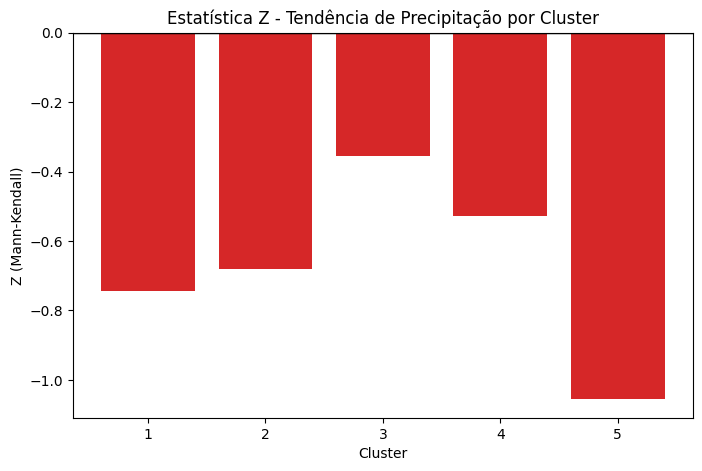

In [86]:
# ============================
# 1. Cálculo de médias por cluster
# ============================
df_clusters = pd.DataFrame({
    "cluster": labels_map.flatten(),
    "slope": slope_freq_epi.values.flatten(),
    "z": z_freq_epi.values.flatten()
})

# Remover NaN
df_clusters = df_clusters.dropna()

# Média de slope e Z por cluster
dados_clusters = df_clusters.groupby("cluster").mean()

# ============================
# 2. Calcular p-valor e significância
# ============================
dados_clusters["p_valor"] = 2 * (1 - stats.norm.cdf(abs(dados_clusters["z"])))
dados_clusters["significativo_95%"] = dados_clusters["p_valor"] < 0.05

# Mostrar tabela resumida
display(dados_clusters)

# ============================
# 3. Plot Estatística Z por cluster
# ============================
plt.figure(figsize=(8,5))
plt.bar(dados_clusters.index,
        dados_clusters["z"],
        color=["#d62728" if not sig else "#1f77b4"
               for sig in dados_clusters["significativo_95%"]])
plt.axhline(0, color='black', linewidth=1)
plt.title("Estatística Z - Tendência de Precipitação por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Z (Mann-Kendall)")
plt.show()

## Conclusão

In [93]:
# Média mensal (1981-2023) por pixel
clim_mensal = precip.groupby("time.month").mean("time")  # dimensões (month, lat, lon)

clusters_ids = sorted(np.unique(labels_map[~np.isnan(labels_map)]).astype(int))
clim_cluster_mensal = []

for cid in clusters_ids:
    mask_cluster = (labels_map == cid)
    # Máscara aplicada na climatologia mensal
    media_cluster = (clim_mensal * mask_cluster).sum(dim=("lat","lon")) / mask_cluster.sum()
    clim_cluster_mensal.append(media_cluster)

# Empilhar resultado em DataArray
clim_cluster_mensal = xr.concat(clim_cluster_mensal, dim="cluster")
clim_cluster_mensal["cluster"] = clusters_ids


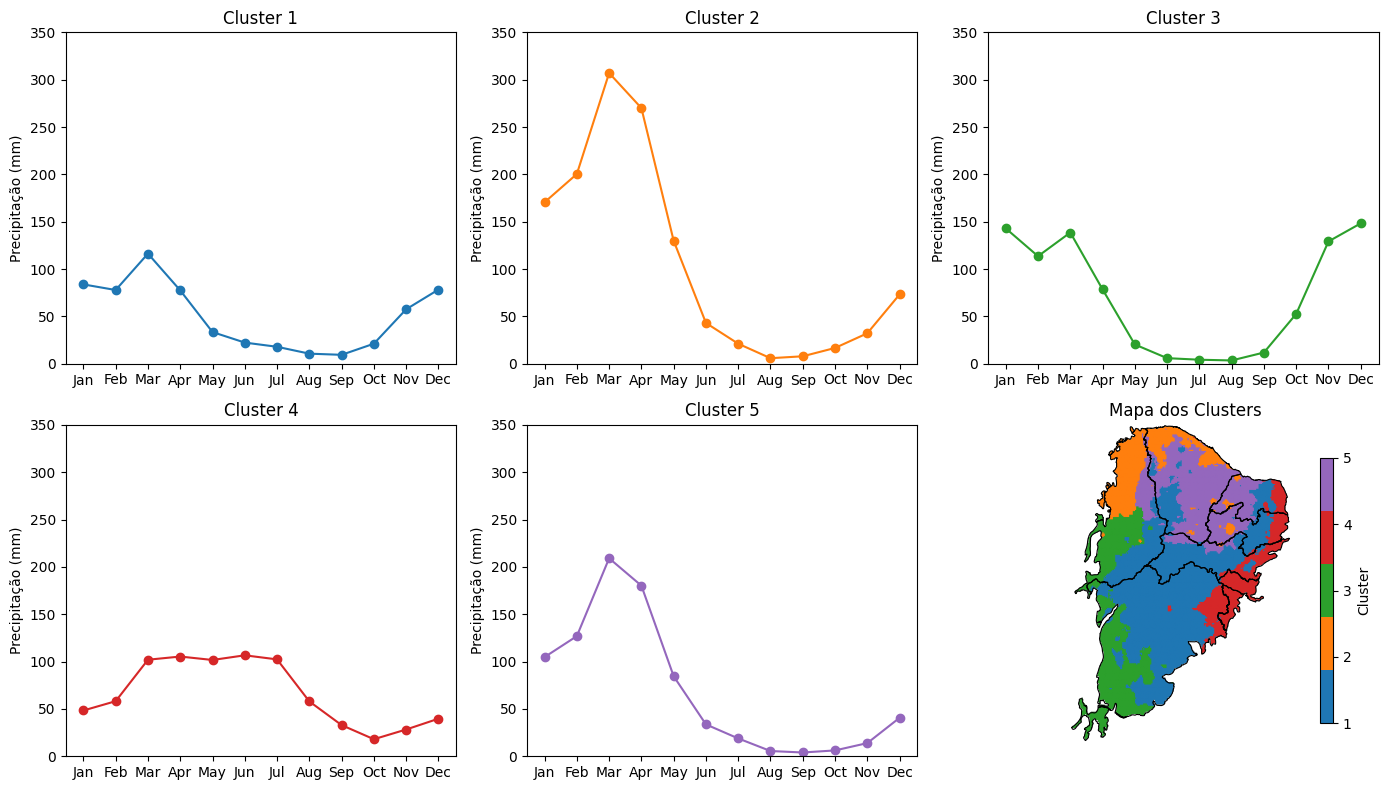

In [104]:
# --------------------------
# 2. Configurar cores (iguais ao mapa)
# --------------------------
cores = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
cmap_categorico = mcolors.ListedColormap(cores[:len(clusters_ids)])

# --------------------------
# 3. Criar figura estilo Oliveira (2015)
# --------------------------
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

# 3.1 Plotar os 5 gráficos de climatologia mensal
for idx, cid in enumerate(clusters_ids):
    dados = clim_cluster_mensal.sel(cluster=cid).values  # série mensal do cluster
    axes[idx].plot(range(1, 13), dados, marker='o', color=cores[idx])
    axes[idx].set_title(f"Cluster {cid}")
    axes[idx].set_xticks(range(1, 13))
    axes[idx].set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    axes[idx].set_ylim(0, 350)  # mesma escala
    axes[idx].set_ylabel("Precipitação (mm)")

# 3.2 Mapa central com clusters
ax_mapa = axes[-1]
ax_mapa.axis("off")  # Desativa eixos

# Plotar clusters
im = ax_mapa.imshow(labels_map, origin="upper",
                    extent=[precip.lon.min(), precip.lon.max(),
                            precip.lat.min(), precip.lat.max()],
                    cmap=cmap_categorico)

# Adicionar barra de cores
cbar = plt.colorbar(im, ax=ax_mapa, ticks=np.arange(1, n_clusters+1), shrink=0.8)
cbar.set_label("Cluster")

# Adicionar contorno dos estados
gdf_estados = gpd.read_file("dataset/shape/caatinga_estados.shp")
gdf_estados.boundary.plot(ax=ax_mapa, color='black', linewidth=0.8)

ax_mapa.set_title("Mapa dos Clusters")

# Ajustar layout
plt.tight_layout()
plt.show()